# Scanning Session Ingestion

## Setup

### Connect to the database

If you are don't have your login information, contact the administrator.

Using local config file (see [01_pipeline](./01_pipeline.ipynb)):

https://github.com/datajoint/workflow-calcium-imaging/blob/main/notebooks/03-process.ipynb
https://github.com/datajoint/workflow-calcium-imaging/blob/main/notebooks/04-automate-optional.ipynb

Check the Moser lab descriptions of useage as well.
https://github.com/kavli-ntnu/dj-docs/blob/master/notebooks/2022-11%20Imaging%20workshop/Working_with_Imaging_pipeline.ipynb

Check the youtube: https://www.youtube.com/watch?v=gFLn0GB1L30

In [2]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
import datajoint as dj; dj.conn()

from adamacs.pipeline import subject, session, surgery, scan, event, trial, imaging
from adamacs import utility
from adamacs.ingest import behavior as ibe
import numpy as np
import scanreader

Manual entry:

In [ ]:
# Manual Entry
import datajoint as dj; import getpass
dj.config['database.host'] = '172.26.128.53'        # Put the server name between these apostrophe
dj.config['database.user'] = 'root'             # Put your user name between these apostrophe
dj.config['database.password'] = getpass.getpass()  # Put your password in the prompt
dj.conn()

from adamacs.pipeline import subject, session, surgery, scan, event, trial, imaging
from adamacs import utility
from adamacs.ingest import behavior as ibe
import numpy as np

## populate scaninfo

In [3]:
scan.ScanInfo.describe()

"# general data about the reso/meso scans from header\n-> scan.Scan\n---\nnfields              : tinyint                      # number of fields\nnchannels            : tinyint                      # number of channels\nndepths              : int                          # Number of scanning depths (planes)\nnframes              : int                          # number of recorded frames\nnrois                : tinyint                      # number of ROIs (see scanimage's multi ROI imaging)\nx=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system\ny=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system\nz=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system\nfps                  : float                        # (Hz) frames per second - Volumetric Scan Rate\nbidirectional        : tinyint                      # true = bidirect

In [3]:
scan.ScanInfo.heading

# general data about the reso/meso scans from header
session_id           : varchar(12)                  # 
scan_id              : varchar(12)                  # 
---
nfields              : tinyint                      # number of fields
nchannels            : tinyint                      # number of channels
ndepths              : int                          # Number of scanning depths (planes)
nframes              : int                          # number of recorded frames
nrois                : tinyint                      # number of ROIs (see scanimage's multi ROI imaging)
x=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
y=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
z=null               : float                        # (um) ScanImage's 0 point in the motor coordinate system
fps                  : float                        # (Hz) frames per second - Volume

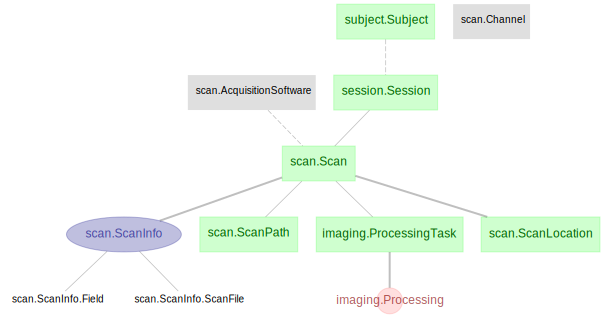

In [4]:
dj.Diagram(subject.Subject) + dj.Diagram(session.Session) + dj.Diagram(scan) + dj.Diagram(imaging.Processing)

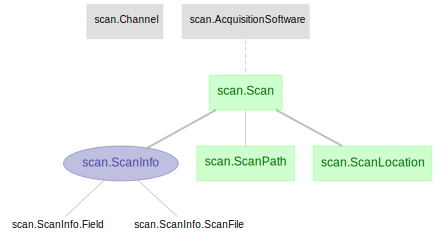

In [16]:
dj.Diagram(scan)

In [ ]:
#scan.ScanInfo.delete()
#scan.Scan.delete()
#session.Session.delete()

In [17]:
scan.Scan()

session_id,scan_id,scanner,acq_software,scan_notes free-notes
sess9FGLEFJ3,scan9FGLEFJ3,mini2p1,ScanImage,Awesome scan
sess9FGLZLRI,scan9FGLZLRI,mini2p1,ScanImage,


In [31]:
scan.Scan() * scan.ScanPath() * session.Session() * session.SessionNote()

session_id,scan_id,user_id,path,scanner,acq_software,scan_notes free-notes,subject PyRat import uses this for earmark value,session_datetime,session_note
sess9FGLEFJ3,scan9FGLEFJ3,7,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-15_scan9FGLEFJ3_sess9FGLEFJ3,mini2p1,ScanImage,Awesome scan,OPI-1681,2023-02-15 00:00:00,Awesome session


In [28]:
scan.ScanLocation()

session_id,scan_id,anatomical_location
sess9FGLEFJ3,scan9FGLEFJ3,dCA1
sess9FGLZLRI,scan9FGLZLRI,RSCa


## populate scan!

In [7]:
populate_settings = {'display_progress': True}

In [8]:
scan.ScanInfo.populate(**populate_settings)
scan.ScanInfo()

session_id,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan
sess9FGLEFJ3,scan9FGLEFJ3,1,1,1,27000,0,nan,nan,nan,29.9784,1,63.1769,0.712867,None,900.648
sess9FGLZLRI,scan9FGLZLRI,1,1,1,5000,0,nan,nan,nan,15.3845,1,250.001,0.95,None,325.002


In [9]:
scan.Scan() * scan.ScanLocation()

session_id,scan_id,scanner,acq_software,scan_notes free-notes,anatomical_location
sess9FGLEFJ3,scan9FGLEFJ3,mini2p1,ScanImage,Awesome scan,dCA1
sess9FGLZLRI,scan9FGLZLRI,mini2p1,ScanImage,,RSCa


In [15]:
scan.ScanInfo()

session_id,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan
sess9FGLEFJ3,scan9FGLEFJ3,1,1,1,27000,0,nan,nan,nan,29.9784,1,63.1769,0.712867,None,900.648
sess9FGLZLRI,scan9FGLZLRI,1,1,1,5000,0,nan,nan,nan,15.3845,1,250.001,0.95,None,325.002


Example to update an entry post-hoc. TODO: imnplement in elements "Scan" function based on userfunction stringa

In [16]:
scan.Scan.update1({'session_id': 'sess9FGLEFJ3', 'scan_id': 'scan9FGLEFJ3', 'scan_notes': "Awesome scan"})

In [29]:
scan.ScanLocation.update1({'session_id': 'sess9FGLEFJ3', 'scan_id': 'scan9FGLEFJ3', 'anatomical_location': "dCA1"})

In [20]:
session.SessionNote.insert1({'session_id': 'sess9FGLEFJ3', 'session_note': "Awesome session"})

In [30]:
session.ProjectSession()

project,session_id
TEC,sess9FGLEFJ3
TEC,sess9FGLZLRI


In [31]:
scan.Scan() 

session_id,scan_id,scanner,acq_software,scan_notes free-notes
sess9FGLEFJ3,scan9FGLEFJ3,mini2p1,ScanImage,Awesome scan
sess9FGLZLRI,scan9FGLZLRI,mini2p1,ScanImage,


In [32]:
scan.ScanLocation()

session_id,scan_id,anatomical_location
sess9FGLEFJ3,scan9FGLEFJ3,dCA1
sess9FGLZLRI,scan9FGLZLRI,RSCa


### Creating a Parameter Set

What exactly happens during processing dependso on the parameter set. This is an example of a parameter set and its insert:

In [3]:
dj.config['custom'].get('suite2p_fast_tmp')[0]

'/home/tobiasr/tmp/'

In [10]:
# Insert the param_set - Mini2p

# TODO: Parameter set needs to be updated with ScanInfo settings

params_suite2p = {'look_one_level_down': False,
                  'fast_disk': dj.config['custom'].get('suite2p_fast_tmp')[0],
                  'delete_bin': True,
                  'mesoscan': False,
                  'h5py': [],
                  'h5py_key': 'data',
                  'save_path0': [],
                  'subfolders': [],
                  'nplanes': 1,
                  'nchannels': 1,
                  'functional_chan': 1,
                  'tau': 1.0,
                  'fs': 15.3845,
                  'force_sktiff': False,
                  'preclassify': 0.0,
                  'save_mat': True,
                  'combined': True,
                  'aspect': 1.0,
                  'do_bidiphase': True,
                  'bidiphase': 0.0,
                  'do_registration': True,
                  'two_step_registration': True,
                  'norm_frames': True,
                  'keep_movie_raw': False,
                  'nimg_init': 1000,
                  'batch_size': 8000,
                  'maxregshift': 0.1,
                  'align_by_chan': 1,
                  'reg_tif': False,
                  'reg_tif_chan2': False,
                  'subpixel': 10,
                  'smooth_sigma_time': 1, 
                  'smooth_sigma': 1.15,
                  'th_badframes': 1.0,
                  'pad_fft': False,
                  'nonrigid': True,
                  'block_size': [64, 64],
                  'snr_thresh': 1.2,
                  'maxregshiftNR': 5.0,
                  '1Preg': False,
                  'spatial_hp': 50.0,
                  'pre_smooth': 2.0,
                  'spatial_taper': 50.0,
                  'roidetect': True,
                  'sparse_mode': True,
                  'denoise': True,
                  'diameter': 6,
                  'spatial_scale': 0,
                  'connected': True,
                  'nbinned': 9000,
                  'max_iterations': 30,
                  'threshold_scaling': 1.0,
                  'max_overlap': 0.75,
                  'high_pass': 100.0,
                  'inner_neuropil_radius': 2,
                  'min_neuropil_pixels': 350,
                  'allow_overlap': False,
                  'chan2_thres': 0.65,
                  'baseline': 'maximin',
                  'win_baseline': 60.0,
                  'sig_baseline': 10.0,
                  'prctile_baseline': 8.0,
                  'neucoeff': 0.7,
                  'xrange': np.array([0, 0]),
                  'yrange': np.array([0, 0])}


In [11]:
imaging.ProcessingParamSet.insert_new_params(
    processing_method="suite2p",
    paramset_idx=0,
    params=params_suite2p,
    paramset_desc="TR: Mini2p (single channel, single plane, non-rigid, 15Hz)",
)


In [7]:
# Insert the param_set - Bench2p

# TODO: Parameter set needs to be updated with ScanInfo settings

params_suite2p = {'look_one_level_down': False,
                  'fast_disk': dj.config['custom'].get('suite2p_fast_tmp')[0],
                  'delete_bin': True,
                  'mesoscan': False,
                  'h5py': [],
                  'h5py_key': 'data',
                  'save_path0': [],
                  'subfolders': [],
                  'nplanes': 1,
                  'nchannels': 1,
                  'functional_chan': 1,
                  'tau': 1.0,
                  'fs': 29.9784,
                  'force_sktiff': False,
                  'preclassify': 0.0,
                  'save_mat': True,
                  'combined': True,
                  'aspect': 1.0,
                  'do_bidiphase': True,
                  'bidiphase': 0.0,
                  'do_registration': True,
                  'two_step_registration': False,
                  'norm_frames': True,
                  'keep_movie_raw': False,
                  'nimg_init': 1000,
                  'batch_size': 8000,
                  'maxregshift': 0.1,
                  'align_by_chan': 1,
                  'reg_tif': False,
                  'reg_tif_chan2': False,
                  'subpixel': 10,
                  'smooth_sigma_time': 1, 
                  'smooth_sigma': 1.15,
                  'th_badframes': 1.0,
                  'pad_fft': False,
                  'nonrigid': True,
                  'block_size': [128, 128],
                  'snr_thresh': 1.2,
                  'maxregshiftNR': 5.0,
                  '1Preg': False,
                  'spatial_hp': 50.0,
                  'pre_smooth': 2.0,
                  'spatial_taper': 50.0,
                  'roidetect': True,
                  'sparse_mode': True,
                  'denoise': True,
                  'diameter': 12,
                  'spatial_scale': 0,
                  'connected': True,
                  'nbinned': 9000,
                  'max_iterations': 30,
                  'threshold_scaling': 1.0,
                  'max_overlap': 0.75,
                  'high_pass': 100.0,
                  'inner_neuropil_radius': 2,
                  'min_neuropil_pixels': 350,
                  'allow_overlap': False,
                  'chan2_thres': 0.65,
                  'baseline': 'maximin',
                  'win_baseline': 60.0,
                  'sig_baseline': 10.0,
                  'prctile_baseline': 8.0,
                  'neucoeff': 0.7,
                  'xrange': np.array([0, 0]),
                  'yrange': np.array([0, 0])}


In [8]:
imaging.ProcessingParamSet.insert_new_params(
    processing_method="suite2p",
    paramset_idx=1,
    params=params_suite2p,
    paramset_desc="TR: Bench2p (single channel, single plane, non-rigid, 30Hz)",
)


In [12]:
imaging.ProcessingParamSet()

paramset_idx,processing_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,suite2p,"TR: Mini2p (single channel, single plane, non-rigid, 15Hz)",96a32724-4dd0-4faf-c88d-6073ad7199a2,=BLOB=
1,suite2p,"TR: Bench2p (single channel, single plane, non-rigid, 30Hz)",c2e80fa9-6fdb-5706-48ac-b15cf1449e92,=BLOB=


In [ ]:
imaging.ProcessingTask().delete()
imaging.ProcessingTask().drop()
imaging.ProcessingParamSet().drop()

### Create and Run a Processing Task

In [20]:
scanquey = 'scan9FGLZLRI'

query =  scan.ScanInfo() & 'scan_id = "' + scanquey + '"'
sess_proc = query.fetch('session_id')[0]
scan_proc = query.fetch('scan_id')[0]

query2 = session.SessionDirectory() & 'session_id = "' + query.fetch('session_id')[0] + '"'
dir_proc = query2.fetch('session_dir')[0]

In [21]:
scanquey = 'scan9FGLEFJ3'
b
sess_proc = query.fetch('session_id')[0]
scan_proc = query.fetch('scan_id')[0]

query2 = session.SessionDirectory() & 'session_id = "' + query.fetch('session_id')[0] + '"'
dir_proc = query2.fetch('session_dir')[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [23]:

query =  scan.ScanInfo() & 'scan_id = "' + scanquey + '"'
query

session_id,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan


In [19]:
scan.ScanInfo()

session_id,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan
sess9FGLZLRI,scan9FGLZLRI,1,1,1,5000,0,nan,nan,nan,15.3845,1,250.001,0.95,None,325.002


In [14]:
imaging.ProcessingTask.insert1((sess_proc,
                                scan_proc,
                                0,
                                dir_proc,
                                'trigger'))

In [15]:
imaging.ProcessingTask()

session_id,scan_id,paramset_idx,processing_output_dir output directory of the processed scan relative to root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation"
sess9FGLZLRI,scan9FGLZLRI,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-16_scan9FGLZLRI_sess9FGLZLRI,trigger


To run all unprocessed processing task we call populate on processing:

In [16]:
imaging.Processing.populate(display_progress=True)

Processing:   0%|          | 0/1 [00:00<?, ?it/s]

using TorchFFT
{'data_path': ['/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-16_scan9FGLZLRI_sess9FGLZLRI'], 'tiff_list': ['/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-16_scan9FGLZLRI_sess9FGLZLRI/scan9FGLZLRI_RN_OPI-1681_00001.tif']}
tif
** Found 1 tifs - converting to binary **
time 1.57 sec. Wrote 5000 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
NOTE: Applying builtin classifier at /home/tobiasr/suite2p/suite2p/classifiers/classifier.npy
----------- REGISTRATION
NOTE: estimated bidiphase offset from data: 0 pixels
Reference frame, 5.65 sec.
Registered 5000/5000 in 19.85s
----------- Total 28.92 sec


Processing:   0%|          | 0/1 [00:38<?, ?it/s]


KeyboardInterrupt: 

In [47]:
for key in (imaging.ProcessingTask - imaging.Curation).fetch('KEY'):
    imaging.Curation().create1_from_processing_task(key)

In [53]:
imaging.Curation()

session_id,scan_id,paramset_idx,curation_id,curation_time time of generation of this set of curated results,"curation_output_dir output directory of the curated results, relative to root data directory",manual_curation has manual curation been performed on this result?,curation_note
sess9FGLZLRI,scan9FGLZLRI,0,1,2023-02-25 17:22:01,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-16_scan9FGLZLRI_sess9FGLZLRI,0,


In [54]:
imaging.MotionCorrection.populate(**populate_settings)

MotionCorrection:   0%|          | 0/1 [00:00<?, ?it/s]


KeyError: 'nblocks'

In [55]:
imaging.Segmentation.populate(**populate_settings)

Segmentation: 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]


In [56]:
imaging.MaskClassification.populate(**populate_settings)

MaskClassification: 100%|██████████| 1/1 [00:00<00:00, 828.42it/s]


In [57]:
imaging.Fluorescence.populate(**populate_settings)

Fluorescence: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


In [58]:
imaging.Activity.populate(**populate_settings)

Activity: 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


AttributeError: 'Activity' object has no attribute 'count'

In [62]:
imaging.ProcessingTask * imaging.Processing & session_key

session_id,scan_id,paramset_idx,processing_output_dir output directory of the processed scan relative to root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation","processing_time time of generation of this set of processed, segmented results",package_version
sess9FGLZLRI,scan9FGLZLRI,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-16_scan9FGLZLRI_sess9FGLZLRI,trigger,2023-02-25 17:22:01,


In [10]:
imaging.ProcessingTask()

session_id,scan_id,paramset_idx,processing_output_dir output directory of the processed scan relative to root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation"
sess9FGLZLRI,scan9FGLZLRI,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-16_scan9FGLZLRI_sess9FGLZLRI,trigger


In [ ]:
imaging.Processing()

In [13]:
session_key = (session.Session & 'subject = "OPI-1681"').fetch('KEY')[0]

In [14]:
scan.ScanInfo.ScanFile()


session_id,scan_id,file_path filepath relative to root data directory
sess9FGLZLRI,scan9FGLZLRI,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-16_scan9FGLZLRI_sess9FGLZLRI/scan9FGLZLRI_RN_OPI-1681_00001.tif


In [15]:
scan.Scan & session_key

session_id,scan_id,scanner,acq_software,scan_notes free-notes
sess9FGLZLRI,scan9FGLZLRI,mini2p1,ScanImage,


In [16]:
scan.ScanInfo & session_key

session_id,scan_id,nfields number of fields,nchannels number of channels,ndepths Number of scanning depths (planes),nframes number of recorded frames,nrois number of ROIs (see scanimage's multi ROI imaging),x (um) ScanImage's 0 point in the motor coordinate system,y (um) ScanImage's 0 point in the motor coordinate system,z (um) ScanImage's 0 point in the motor coordinate system,fps (Hz) frames per second - Volumetric Scan Rate,bidirectional true = bidirectional scanning,usecs_per_line microseconds per scan line,fill_fraction raster scan temporal fill fraction (see scanimage),scan_datetime datetime of the scan,scan_duration (seconds) duration of the scan
sess9FGLZLRI,scan9FGLZLRI,1,1,1,5000,0,nan,nan,nan,15.3845,1,250.001,0.95,None,325.002


In [17]:
scan.ScanInfo.Field & session_key

session_id,scan_id,field_idx,px_height height in pixels,px_width width in pixels,um_height height in microns,um_width width in microns,field_x (um) center of field in the motor coordinate system,field_y (um) center of field in the motor coordinate system,field_z (um) relative depth of field,delay_image (ms) delay between the start of the scan and pixels in this field,roi the scanning roi (as recorded in the acquisition software) containing this field - only relevant to mesoscale scans
sess9FGLZLRI,scan9FGLZLRI,0,256,256,164.491,164.491,nan,nan,nan,=BLOB=,None


In [18]:
imaging.ProcessingParamSet()

paramset_idx,processing_method,paramset_desc,param_set_hash,params dictionary of all applicable parameters
0,suite2p,"Mini2p (single channel, single plane, 15Hz)",04677ecd-83f1-6298-acd9-ce8fa775e7a7,=BLOB=


In [19]:
imaging.ProcessingTask * imaging.Processing & session_key

session_id,scan_id,paramset_idx,processing_output_dir output directory of the processed scan relative to root data directory,"task_mode 'load': load computed analysis results, 'trigger': trigger computation","processing_time time of generation of this set of processed, segmented results",package_version
sess9FGLZLRI,scan9FGLZLRI,0,/datajoint-data/data/tobiasr/RN_OPI-1681_2023-02-16_scan9FGLZLRI_sess9FGLZLRI,trigger,2023-02-25 17:22:01,


In [20]:
imaging.Curation & session_key

session_id,scan_id,paramset_idx,curation_id,curation_time time of generation of this set of curated results,"curation_output_dir output directory of the curated results, relative to root data directory",manual_curation has manual curation been performed on this result?,curation_note


Scanreader payload testing

In [21]:
path = scan.ScanInfo.ScanFile().fetch('file_path')[0]
infoscan = scanreader.read_scan(path)

In [25]:
infoscan.fpd

AttributeError: 'Scan2022' object has no attribute 'fpd'

In [26]:

infoscan.user_funtion


AttributeError: 'Scan2022' object has no attribute 'user_funtion'

In [ ]:
scan.ScanInfo()

In [ ]:
session.Session()

In [ ]:
Sess